<h1><center>HW3</center></h1>

104061172 張肇元

<h1>Implement</h1>

* 利用上課所學去實作一個機器學習的分類 model
* 這次實作中的 dataset 改成 28x28 的圖片，也就是說一共有784種 feature
* 運用 ski-learn 的 library 幫助我coding ，雖然老師講義有 source code，不過 ski-learn 有包裝好的函示可以 call
* 因為 data和 feature 量都非常多，所以我會先看 eigenvalue 然後運用 pca lda 來實作
* 此外，我還想測試不同 model 對 classification 的影響
* 我把code 拆成一部分一部分去解釋我在寫這部分思考的事情

<h1>1.1 Code and Result</h1>

In [1]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import time
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression as LR
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier as KNN

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.16, random_state=1,stratify = y_train)
    
x_train.resize(50400,28*28)
x_val.resize(9600,28*28)
x_test.resize(10000,28*28)

print("x_train shape:", x_train.shape, "y_train shape:", y_train.shape)

D:\anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


x_train shape: (50400, 784) y_train shape: (50400,)


因為讀進來的 data 是二維的圖片，所以我打算把他轉成一維的矩陣，方便我在之後 pca 或是 lda等使用

In [2]:
sc = StandardScaler()
x_train_std = sc.fit_transform(x_train)
x_val_std = sc.transform(x_val)
x_test_std = sc.transform(x_test)

D:\anaconda\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


在這裡對圖片進行 standardlization

In [4]:
cov_mat = np.cov(x_train_std.T)
eigenvals , eigenvec = np.linalg.eig(cov_mat)
tot = sum (eigenvals)
var_exp  = [(i/tot) for i in sorted(eigenvals , reverse= True)]
cum_var_exp =  np.cumsum(var_exp)

In [5]:
import matplotlib.pyplot as plt
plt.bar(range(1,50), var_exp[0:49] ,alpha = 0.5 , align = 'center')
plt.step(range(1,50),cum_var_exp[0:49],where = 'mid')
plt.tight_layout()
plt.show()

<Figure size 640x480 with 1 Axes>

上面兩個 block 會將每一個 feature 的 eigen value 算出來，然後再將它畫出來，從這邊我觀察到feature 大概到25之後他的影響力就微乎其微了，在這邊我猜 30 個 component 會讓我的 model 有不錯的結果，因為用 30 個 component 就可以 cover 75% 的 

In [3]:
pca = PCA(n_components=30)
x_train_pca = pca.fit_transform(x_train_std)
x_val_pca = pca.transform(x_val_std)

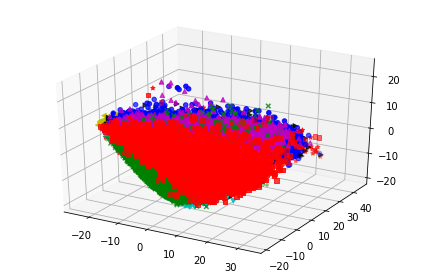

In [7]:
colors = ['r' , 'g' , 'b' , 'c' , 'm' , 'y' , 'k' , 'b' , 'r' , 'g' ]
markers = ['s' , 'x' , 'o','v','^','<','>','p','*','+']
ax = plt.subplot(111,projection = '3d')
for l , c , m in zip (np.unique(y_train) , colors , markers):
    ax.scatter(x_train_pca[y_train == l , 0] , x_train_pca[y_train == l,1] , x_train_pca[y_train == l , 2] , c=c , label = l , marker= m)
plt.tight_layout()
plt.show()

從這張圖片可以看出來，再取前三個 principal component 後，我們的 data 事實上是不能用 linear model 的，另外，這張圖在 vscode 上可以旋轉，可以觀察更清楚，所以我決定捨棄 linear model。

做完 PCA 第一個想到的是 KNN 因為它最直觀，同時也有辦法處理非線性的 data

In [17]:
for i in range(1,30,2):
    t1 = time.time()
    knn = KNN(n_neighbors = i)
    knn.fit(x_train_pca,y_train)
    k_pred = knn.predict(x_val_pca)
    t2 = time.time()
    print('Accuracy = %.3f' % accuracy_score(y_val, k_pred))
    print('time = %f' % (t2-t1))

Accuracy = 0.830
time = 5.972486
Accuracy = 0.844
time = 7.380060
Accuracy = 0.850
time = 8.187353
Accuracy = 0.851
time = 8.617277
Accuracy = 0.855
time = 9.057733
Accuracy = 0.856
time = 9.411162
Accuracy = 0.854
time = 9.643010
Accuracy = 0.853
time = 9.890867
Accuracy = 0.850
time = 10.179057
Accuracy = 0.851
time = 10.357306
Accuracy = 0.850
time = 10.638354
Accuracy = 0.849
time = 10.808223
Accuracy = 0.850
time = 10.953601
Accuracy = 0.849
time = 11.121793
Accuracy = 0.848
time = 11.266943


看起來這個演算法還不錯，爾且消耗的時間也不多，另外，這是固定 component = 30 的結果，如果 component 更多，model 應該可以更精準，不過這個 model 的 neighbors 在 9 ~ 11 之間大概就是極限了。

In [8]:
t1 = time.time()
svm = SVC(kernel='rbf',random_state=1,gamma= 1./30.,C=10)
svm.fit(x_train_pca,y_train)
y_pred = svm.predict(x_val_pca)
k = y_pred.size
y_pred.resize(k,1)
print('%.2f' % accuracy_score(y_val, y_pred))
t2 = time.time()
print('time = %.2f' % (t2-t1))

0.82
time = 363.61


KNN 之後，我想到的就是在上一次作業中表現亮眼的 rbf SVM 所以我決定拿這個 model 來試試看。

In [56]:
for i in range(25,41,5):
    t1 = time.time()
    pca_iter = PCA(n_components=i)
    x_train_pca = pca_iter.fit_transform(x_train_std)
    x_val_pca = pca_iter.transform(x_val_std)
    svm = SVC(kernel='rbf',random_state=1,gamma= 'auto',C=10)
    svm.fit(x_train_pca,y_train)
    y_pred = svm.predict(x_val_pca)
    k = y_pred.size
    y_pred.resize(k,1)
    t2 = time.time()
    print('As PCA for n = %d component:' % i)
    print('%.2f' % accuracy_score(y_val, y_pred))
    print('time = %.2f' % (t2-t1))

As PCA for n = 25 component:
0.81
time = 305.60
As PCA for n = 30 component:
0.82
time = 354.55
As PCA for n = 35 component:
0.82
time = 386.21
As PCA for n = 40 component:
0.83
time = 418.78


一如預期，多個 component 確實能有越好的 performance 但是，上升的趨勢並不是很明顯，從上面 eigen value 的圖片可以很清楚的解釋，對 model 影響很大的 eigen value 大概是在 30 之前，所以在 30 後面要增加較多 accuracy 一次是要多很多。

In [6]:
t1 = time.time()
lr = LR(penalty = 'l2')
lr.fit(x_train_pca,y_train)#PCA , n = 40
lr_pred = lr.predict(x_val_pca)
t2 = time.time()
print('%.2f' % accuracy_score(y_val, lr_pred))
print('time = %.2f' % (t2-t1))

0.81
time = 21.54


這時候我想到 logistic regression 也可以用來做 unlinear separabel 的 data classification ，所以我想用它來試試看，我也有試過不加 penalty ，可是對 accuracy 沒有太顯著的影響，雖然 accuracy 下降了，但是他的時間損耗非常少，不過這也是應該的，因為參考資料中有提到 logistic regression 的複雜度是 $O(n)$ 但是他還有 iterator 幾次才能收斂的問題，而 SVM 是 $O(n^2) 到 O(n^3)$之間，感覺有希望了，說不定我參數調一調，可以有更好的 accuracy! 

In [17]:
lr_c = [0.01,0.1,1,10,100,1000]
for i in lr_c :
    t1 = time.time()
    print("C = %f" % i)
    lr = LR(penalty = 'l2',C = i,random_state = 1)
    lr.fit(x_train_pca,y_train)
    t2 = time.time()
    print('%.2f' % accuracy_score(y_val, lr_pred))
    print('time = %.2f' % (t2-t1))

C = 0.010000
0.81
time = 13.84
C = 0.100000
0.81
time = 17.49
C = 1.000000
0.81
time = 23.03
C = 10.000000
0.81
time = 23.65
C = 100.000000
0.81
time = 23.87
C = 1000.000000
0.81
time = 23.92


那在 n component 不變(40)的情況下，去調整 C 的大小，結果發現 accuracy 都沒有變化。
所以我決定試試看其他的方法來做 classification。

In [8]:
lda = LDA(n_components = 30)
x_train_lda = lda.fit_transform(x_train_std,y_train)
x_val_lda = lda.transform(x_val_std)

第一個想到的就是 LDA 因為老師在上課講說，做完 PCA 常常會做 LDA 去看結果，然後再和 PCA 比較;
那根據上個 PCA 的結果，我把 component 設定在 30。

先試試看非常直覺的 KNN classifier

In [18]:
for i in range(1,30,2):
    t1 = time.time()
    knn = KNN(n_neighbors = i)
    knn.fit(x_train_lda,y_train)
    k_pred = knn.predict(x_val_lda)
    t2 = time.time()
    print('Accuracy = %.3f' % accuracy_score(y_val, k_pred))
    print('time = %f' % (t2-t1))

Accuracy = 0.803
time = 0.652397
Accuracy = 0.823
time = 0.880020
Accuracy = 0.832
time = 0.998488
Accuracy = 0.835
time = 1.121911
Accuracy = 0.838
time = 1.101369
Accuracy = 0.840
time = 1.139753
Accuracy = 0.839
time = 1.243667
Accuracy = 0.839
time = 1.282539
Accuracy = 0.839
time = 1.331218
Accuracy = 0.842
time = 1.332412
Accuracy = 0.841
time = 1.373728
Accuracy = 0.841
time = 1.424880
Accuracy = 0.842
time = 1.451607
Accuracy = 0.843
time = 1.498049
Accuracy = 0.843
time = 1.508448


accuracy 和 pca 好像有一點差距。不過執行的速度快蠻多的。

In [10]:
t1 = time.time()
svm = SVC(kernel = 'rbf' , random_state = 1 , gamma = 1./30. , C = 10)
svm.fit(x_train_lda,y_train)
y_pred = svm.predict(x_val_lda)
q = y_pred.size
y_pred.resize(q,1)
t2 = time.time()
print('As LDA for n = 30 component:')
print('%.2f' % accuracy_score(y_val, y_pred))
print('time = %f' % (t2-t1))

As LDA for n = 30 component:
0.85
time = 24.411816


還不錯，真的不錯，因為 accuracy 上升了，而且需要運算的時間也變少很多。

In [14]:
for i in range(25,41,5):
    t1 = time.time()
    lda = LDA(n_components = i)
    x_train_lda = lda.fit_transform(x_train_std,y_train)
    x_val_lda = lda.transform(x_val_std)
    svm = SVC(kernel = 'rbf' , random_state = 1 , gamma = 'auto' , C = 10)
    svm.fit(x_train_lda,y_train)
    y_pred = svm.predict(x_val_lda)
    q = y_pred.size
    y_pred.resize(q,1)
    t2 = time.time()
    print('As LDA for n = %d component:' %i)
    print('%.2f' % accuracy_score(y_val, y_pred))
    print('time = %f' % (t2-t1))
    t1 = time.time()
    lr = LR()
    lr.fit(x_train_lda,y_train)
    lr_pred = lr.predict(x_val_lda)
    t2 = time.time()
    print('lr for n = %d component' %i)
    print('%.2f' % accuracy_score(y_val, lr_pred))
    print('time = %.2f' % (t2-t1))

As LDA for n = 25 component:
0.85
time = 41.068953
lr for n = 25 component
0.83
time = 3.55
As LDA for n = 30 component:
0.85
time = 43.862460
lr for n = 30 component
0.83
time = 3.44
As LDA for n = 35 component:
0.85
time = 40.679926
lr for n = 35 component
0.83
time = 4.33
As LDA for n = 40 component:
0.85
time = 43.394558
lr for n = 40 component
0.83
time = 3.87


這樣看起來 25-40 之間 component 的數量對 lda 沒有太大的影響，不過有一個很棒的消息是運用 LDA 降維比起 PCA 可以讓 SVM 和 Logistic regression 的速度加快 10 倍

In [9]:
lda = LDA(n_components = 25)
x_train_lda = lda.fit_transform(x_train_std,y_train)
x_val_lda = lda.transform(x_val_std)
gamma_range = [ 0.00001 , 0.0001 , 0.001 , 0.01 , 0.1 , 1 ]
c_range = [ 0.01 , 0.1 , 1 , 10 , 100 , 1000 ]

for g in gamma_range:
    for c in c_range:
        t1 = time.time()
        svm = SVC(kernel = 'rbf' , random_state = 1 , gamma = g , C = c)
        svm.fit(x_train_lda,y_train)
        y_pred = svm.predict(x_val_lda)
        q = y_pred.size
        y_pred.resize(q,1)
        t2 = time.time()
        print('As LDA for n = 25 component, gamma = %f , c = %f:' % (g,c) )
        print('Accuracy = %.2f' % accuracy_score(y_val, y_pred))
        print('time = %f' % (t2-t1))

As LDA for n = 25 component, gamma = 0.000010 , c = 0.010000:
Accuracy = 0.81
time = 216.045700
As LDA for n = 25 component, gamma = 0.000010 , c = 0.100000:
Accuracy = 0.81
time = 198.981548
As LDA for n = 25 component, gamma = 0.000010 , c = 1.000000:
Accuracy = 0.82
time = 96.704701
As LDA for n = 25 component, gamma = 0.000010 , c = 10.000000:
Accuracy = 0.83
time = 39.173065
As LDA for n = 25 component, gamma = 0.000010 , c = 100.000000:
Accuracy = 0.83
time = 20.405772
As LDA for n = 25 component, gamma = 0.000010 , c = 1000.000000:
Accuracy = 0.83
time = 17.510001
As LDA for n = 25 component, gamma = 0.000100 , c = 0.010000:
Accuracy = 0.81
time = 222.774506
As LDA for n = 25 component, gamma = 0.000100 , c = 0.100000:
Accuracy = 0.82
time = 105.061044
As LDA for n = 25 component, gamma = 0.000100 , c = 1.000000:
Accuracy = 0.83
time = 47.878040
As LDA for n = 25 component, gamma = 0.000100 , c = 10.000000:
Accuracy = 0.83
time = 27.756820
As LDA for n = 25 component, gamma = 0.

本來想用 gridsearch 的，可是我睡覺的時候，放著給他跑，他跑一跑就沒有 output 出結果，可能是因為跑太久，我的電腦就自己關機了，後來我覺得反正 grid search 主體就是三層的巢狀迴圈，我可以自己做一個，而且在我決定捨棄 linear model 的情況下，我只要跑兩層，同時我也可以設定我的 gamma 和 c 的 range ，不用讓他去跑和老師參考資料中，差很遠的值，而且從最後的趨勢上來看， gamma 是不會太大，而 c 是不會太小和我原先的猜測是相同的。
這些 output 的結果讓我可以觀察得知，gamma 和 c 大致上的範圍。

那接著我想要實作用 feature 來當分辨依據的 randomforest

In [7]:
from sklearn.ensemble import RandomForestClassifier as RFC
lda = LDA(n_components = 25)
x_train_lda = lda.fit_transform(x_train_std,y_train)
x_val_lda = lda.transform(x_val_std)
t1 = time.time()
rf = RFC(criterion = 'entropy' ,n_estimators = 25 ,random_state = 1 , n_jobs = -1)
rf.fit(x_train_lda,y_train)
tree_pred = rf.predict(x_val_lda)
print('Accuracy = %.2f' % accuracy_score(y_val, tree_pred))
t2 = time.time()
print('time = %f' % (t2-t1))

Accuracy = 0.84
time = 3.072466


用 forest 來做變很快，不過這也是理所當然的，因為他不用經過很多次的 iterator 所以她的複雜度會是 $O( ntree * mtry * nlog(n) )$
ntree 是幾個棵樹，mtry 是幾個變數，不過這兩個都會是常數，所以她的複雜度其實會接近 $O(nlog(n))$
但是他的 accuracy 和 消耗的時間和 logistic regreesion 和 SVC 相比十分亮眼

In [61]:
estimators = [10,15,20,25,30,35]
depth = [1,5,9,13,17,21,None] 
best_en = 0.0
best_gi = 0.0
en_es = 10
en_d = 1
gi_es = 10
gi_d = 1
for i in estimators:
    for d in depth:
        t1 = time.time()
        rf = RFC(criterion = 'entropy' ,n_estimators = i ,random_state = 1 , n_jobs = -1,max_depth = d)
        rf.fit(x_train_lda,y_train)
        tree_pred = rf.predict(x_val_lda)
        #print('For criterion = entropy , %d estimators , %s max_depth randomforest:' % (i,str(d)))
        #print('Accuracy = %.3f' % accuracy_score(y_val, tree_pred))
        t2 = time.time()
        print('time = %f' % (t2-t1))
        a = accuracy_score(y_val, tree_pred)
        if a > best_en:
            best_en = a
            en_es = i
            en_d = d
        else :
            pass
for i in estimators:
    for d in depth:
        t1 = time.time()
        rf = RFC(criterion = 'gini' ,n_estimators = i ,random_state = 1 , n_jobs = -1,max_depth = d)
        rf.fit(x_train_lda,y_train)
        tree_pred = rf.predict(x_val_lda)
        #print('For criterion = gini , %d estimators , %s max_depth randomforest:' % (i,str(d)))
        #print('Accuracy = %.3f' % accuracy_score(y_val, tree_pred))
        t2 = time.time()
        print('time = %f' % (t2-t1))
        a = accuracy_score(y_val, tree_pred)
        if a > best_gi:
            best_gi = a
            en_es = i
            en_d = d
        else :
            pass
if best_en > best_gi:
    print("entorpy , acc = %.3f , estimator = %d , depth = %s "%(best_en,en_es,str(en_d)))
else:
    print("gini , acc = %.3f , estimator = %d , depth = %s "%(best_gi,gi_es,str(gi_d)))

time = 0.524996
time = 0.957809
time = 1.250059
time = 1.462231
time = 1.573364
time = 1.565498
time = 1.563515
time = 0.628754
time = 1.165061
time = 1.650385
time = 1.755302
time = 1.779195
time = 1.861758
time = 1.891613
time = 0.636581
time = 1.466607
time = 2.066131
time = 2.693263
time = 2.504675
time = 2.437174
time = 2.455130
time = 0.731214
time = 1.816260
time = 2.549291
time = 2.795477
time = 2.988578
time = 3.014215
time = 3.003861
time = 0.734866
time = 1.891354
time = 2.752405
time = 3.006266
time = 3.316127
time = 3.300211
time = 3.293248
time = 0.837308
time = 2.253656
time = 3.280321
time = 3.551035
time = 3.910163
time = 3.956084
time = 3.863874
time = 0.398166
time = 0.623454
time = 0.736608
time = 0.844300
time = 0.937844
time = 0.956370
time = 0.958138
time = 0.507042
time = 0.630186
time = 0.844283
time = 0.940813
time = 1.037994
time = 1.049208
time = 1.060277
time = 0.513643
time = 0.734989
time = 0.952642
time = 1.169878
time = 1.277939
time = 1.379583
time = 1

所以我決定 tune 看看參數，看會有什麼結果，原本 depth 是參考講義上的變數設計的，不過我有在思考是不是一次不要 +1 而是 +3 ~ +5 會是更好 tune 參數的選法，畢竟我的 feature 還蠻多的，所以我後來決定讓他一次增加 4。

結果顯示:
在 lda 最後的 model 會選用 entropy 因為在 lda 中他擁有最好的 accuracy ，其實我有去看 gini 的它們的 accuracy 相差不大。
不過我還是很迷信 validation 的 score ，所以在 parameter 上我會選擇 n_estimators = 15 , max_depth = 13 這一組的參數。
另外再選擇最後 testing 的 model 的話，我偏向 ramdom forest ，因為她速度快 ， accuracy 又只下降大概 1 % ，我比較喜歡這組的演算法。

In [62]:
pca = PCA(n_components=25)
x_train_pca = pca.fit_transform(x_train_std)
x_val_pca = pca.transform(x_val_std)

In [65]:
estimators = [10,15,20,25,30,35]
depth = [1,5,9,13,17,21,None] 
best_en = 0.0
best_gi = 0.0
en_es = 10
en_d = 1
gi_es = 10
gi_d = 1
for i in estimators:
    for d in depth:
        t1 = time.time()
        rf = RFC(criterion = 'entropy' ,n_estimators = i ,random_state = 1 , n_jobs = -1,max_depth = d)
        rf.fit(x_train_pca,y_train)
        tree_pred = rf.predict(x_val_pca)
        #print('For criterion = entropy , %d estimators , %s max_depth randomforest:' % (i,str(d)))
        #print('Accuracy = %.3f' % accuracy_score(y_val, tree_pred))
        t2 = time.time()
        print('time = %f' % (t2-t1))
        a = accuracy_score(y_val, tree_pred)
        if a > best_en:
            best_en = a
            en_es = i
            en_d = d
        else :
            pass
for i in estimators:
    for d in depth:
        t1 = time.time()
        rf = RFC(criterion = 'gini' ,n_estimators = i ,random_state = 1 , n_jobs = -1,max_depth = d)
        rf.fit(x_train_pca,y_train)
        tree_pred = rf.predict(x_val_pca)
        #print('For criterion = gini , %d estimators , %s max_depth randomforest:' % (i,str(d)))
        #print('Accuracy = %.3f' % accuracy_score(y_val, tree_pred))
        t2 = time.time()
        print('time = %f' % (t2-t1))
        a = accuracy_score(y_val, tree_pred)
        if a > best_gi:
            best_gi = a
            en_es = i
            en_d = d
        else :
            pass
if best_en > best_gi:
    print("entorpy , acc = %.3f , estimator = %d , depth = %s "%(best_en,en_es,str(en_d)))
else:
    print("gini , acc = %.3f , estimator = %d , depth = %s "%(best_gi,gi_es,str(gi_d)))

time = 0.616271
time = 1.575651
time = 2.209007
time = 2.511053
time = 2.554041
time = 2.629269
time = 2.624027
time = 0.750861
time = 1.760074
time = 2.474874
time = 3.071159
time = 3.119256
time = 3.236306
time = 3.144686
time = 0.850213
time = 2.386791
time = 3.500215
time = 4.408300
time = 4.307814
time = 4.507115
time = 4.128214
time = 0.934337
time = 2.852654
time = 4.355221
time = 5.525093
time = 5.960297
time = 6.177723
time = 5.676483
time = 0.983790
time = 3.244114
time = 4.886903
time = 5.828020
time = 5.804697
time = 6.259758
time = 6.107979
time = 1.165656
time = 3.855623
time = 5.499861
time = 6.313181
time = 7.485085
time = 7.192425
time = 7.129802
time = 0.526895
time = 0.851486
time = 1.058888
time = 1.249185
time = 1.497332
time = 1.451582
time = 1.340440
time = 0.530154
time = 0.831273
time = 1.123967
time = 1.279893
time = 1.364567
time = 1.886775
time = 1.700811
time = 0.624671
time = 1.189846
time = 1.384015
time = 1.670163
time = 1.796548
time = 1.893946
time = 1

In [49]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import VotingClassifier
pca = PCA(n_components=25)
x_train_pca = pca.fit_transform(x_train_std)
x_val_pca = pca.transform(x_val_std)
t1 = time.time()
clf1 = RFC(criterion = 'entropy' ,n_estimators = 30 ,random_state = 1 , n_jobs = -1,max_depth = None)

pipe1 = make_pipeline(clf1)

clf2 = KNN(n_neighbors = 11)

pipe2 = make_pipeline(clf2)

clf3 = LR(penalty = 'l2',C = 10)

pipe3 = make_pipeline(clf3)

v_clf = VotingClassifier(estimators = [('p1',pipe1),('p2',pipe2),('p3',pipe3)],voting='hard',weights=[2,1,1])
v_clf.fit(x_train_pca,y_train)
v_pred = v_clf.predict(x_val_pca)
t2 = time.time()
print('Accuracy = %.3f' % accuracy_score(y_val, v_pred))
print('time = %f' % (t2-t1))

Accuracy = 0.859
time = 30.936237


D:\anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


好吧，看來用 voting 加上因為 RF 比較準，所以我給他的 weight 比較重一點，並不能得到超越 Random forest 的結果。
而且這個 voting 的結果是浮動的，範圍會從 0.857 震盪到 0.860

In [47]:
lda = LDA(n_components = 25)
x_train_lda = lda.fit_transform(x_train_std,y_train)
x_val_lda = lda.transform(x_val_std)
t1 = time.time()
clf1 = RFC(criterion = 'entropy' ,n_estimators = 15 ,random_state = 1 , n_jobs = -1,max_depth = 13)

pipe1 = make_pipeline(clf1)

clf2 = KNN(n_neighbors = 29)

pipe2 = make_pipeline(clf2)

clf3 = SVC(kernel='rbf',random_state=1,gamma= 0.1 , C=10)

pipe3 = make_pipeline(clf3)

v_clf = VotingClassifier(estimators = [('pipe1',pipe1),('p2',pipe2),('pipe3',pipe3)],voting='hard',weights=[2,2,3])
v_clf.fit(x_train_lda,y_train)
v_pred = v_clf.predict(x_val_lda)
t2 = time.time()
print('Accuracy = %.3f' % accuracy_score(y_val, v_pred))
print('time = %f' % (t2-t1))

Accuracy = 0.847
time = 34.906055


D:\anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [50]:
t1 = time.time()
x_test_pca = pca.transform(x_test_std)
test_pred = v_clf.predict(x_test_pca)
t2 = time.time()
print('Accuracy = %.3f' % accuracy_score(y_test, test_pred))
print('with pca ,time = %f' % (t2-t1))
t1 = time.time()
rf = RFC(criterion = 'entropy' ,n_estimators = 30 ,random_state = 1 , n_jobs = -1,max_depth = None)
rf.fit(x_train_pca,y_train)
test_pred = rf.predict(x_test_pca)
t2 = time.time()
print('Accuracy = %.3f' % accuracy_score(y_test, test_pred))
print('with pca ,time = %f' % (t2-t1))

D:\anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Accuracy = 0.843
with pca ,time = 7.916530
Accuracy = 0.842
with pca ,time = 6.336123


所以根據 validation 的 score 選擇的 model 得出的 accuracy 算是符合預期。
那最後選擇的 model 是 pca 的 parameter [ n_estimater = 30 , max_depth = None ] 的 random forest，和包含 Logestic Regression ， SVC ， KNN 的 voting Classifier ，因為兩個的準確度相當，只是後者的準確率似乎不是一個定值。    
最後把這組 model 拿去和 testing data 做測試，結果是降了大約 0.015 的準確度，算是非常正常的，畢竟為了避免 cheating ，我沒有根據 testing 去調整 parameter，因為我想確定當我在測試 testing data 時，我是 unseen 的。

<h1>Discussion</h1>

會在 nomalization 和 standardlization 中選擇 standardlization 是因為我認為這次的資料 ( pixel value ) 都是在 0 - 255 之間，他的資料跨度其實沒有很大，很明顯的差別，所以我才會覺得用 standardlization 應該就能有不錯的效果了。

原來機器學習在等待時，是如此煎熬的時間，因為真的很想趕快知道結果是什麼。在這次的作業中，我學到了好的參數可以減少 model 的 iterater 的次數，可以加快 training 的時間，同時我也有去看 sklearn model 的 document ，了解每個 model 中，他們參數是對應到甚麼東西，還有他們各自的 complexity 是多少，除此之外，也對於 model 有很多 feature 開始有實作的經驗，因為事實上在這次的作業中，我們知道一張圖片中，其實重要的 feature point 並沒有那麼多。還有在 PCA 或 LDA 中其實只要選擇的 component 超過 65 %其實就可以有不錯的效果了，我有另外去看其他 component 後的 accuracy score ，我發現在 component 等於 20 時其實 accuracy 還是有 81 %

另外，我在完成這些 blocks 之後我有想到，如果一開始就使用 kernal rbf pca 的話，那其實我就可以用 Linear separable model 去做分類:
不過後來思考後覺得其實還蠻沒有意義的，因為 SVM 的 rbf 其實就是在做類似的事情了，而且他也是用在 rbf 後他也是用 marginal gain  去找出一個線性分類的方法，所以後來就沒有再做下去。

因為 random forest 的速度很快，所以我也蠻好奇如果整組 data 都進去會發生什麼事情:

In [74]:
t1 = time.time()
rf = RFC(criterion = 'entropy' ,n_estimators = 30 ,random_state = 1 , n_jobs = -1,max_depth = None)
rf.fit(x_train_std,y_train)
test_pred = rf.predict(x_test_std)
print('Accuracy = %.3f' % accuracy_score(y_test, test_pred))
t2 = time.time()
print('entropy without pca & lda ,time = %f' % (t2-t1))

Accuracy = 0.869
entropy without pca & lda ,time = 5.851580


結果 accuracy 從 0.845 -> 0.869 而且速度也差不多，不過實際上使用的 component 就多非常多了。
不過是結果也是可預期的，畢竟使用的 component 本來就比 pca 還多了，那結果比他好也是很正常的。
從結果看來，如果不是用 random forest 而是用 SVC 的話，這整組資料丟進去 fit 可能要非常久的時間才有機會 output 出結果。
而且用 pca 或 lda 也可以幫助我們快速的找到 hyper parameter ，是很厲害的作法!
最後，難怪 random forest 會是最近備受青睞的一種 classifier ，因為跑起來複雜度不高，還設定 workers ， accuracy 表現又十分亮眼，不過這個model 如果遇到 data 有 scale ， 或是有 offset 過可能就沒辦法有這麼好的效果了，這時候還是需要 CNN 來進行影像辨識了。

<h1>Reference</h1>

https://stats.stackexchange.com/questions/102823/libsvm-rbf-kernel-time-complexity    
ML 上課講義    
https://stats.stackexchange.com/questions/10289/whats-the-difference-between-normalization-and-standardization     
https://www.quora.com/What-is-the-time-complexity-of-a-Random-Forest-both-building-the-model-and-classification